# Asteroids
## CPSC 322, Fall 2024
### Leo Jia & Mark Sanghera

## Introduction



Our classification task was to determine if a NEO is hazardous (true/false).

#### Classifications

1. Naive Bayes Classifier
2. Decision Trees Classifier
3. Random Forest Classifier

In [9]:
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import plot_utils

# Data Analysis

The dataset used in this project consists of ~90,000 isntances NEO (Near Earth Object) observations, with attributes: id, name, est_diameter_min, est_diameter_max, relative_velocity, miss_distance, orbiting_body, sentry_object, absolute_magnitude, hazardous.

The cleaned dataset consists of the attributes: est_diameter_min, est_diameter_max, relative_velocity, miss_distance, absolute_magnitude, hazardous.

### Clean Dataset for unused attributes

In [ ]:
from mysklearn.mypytable import MyPyTable 
import random

file_path = "/home/FinalProject/neo.csv"
output_file = "/home/FinalProject/neo_clean.csv"
neo_table = MyPyTable()
neo_table.load_from_file(file_path)

# attributes to remove
removed_attributes = ["id", "name", "orbiting_body", "sentry_object"]

columns_to_keep = [col for col in neo_table.column_names if col not in removed_attributes]

hazardous_index = neo_table.column_names.index("hazardous")

# Separate hazardous and non-hazardous rows
hazardous_rows = []
non_hazardous_rows = []

for row in neo_table.data:
    if row[hazardous_index].lower() == "true":
        hazardous_rows.append(row)
    else:
        non_hazardous_rows.append(row)

# Calculate how many non-hazardous rows to keep
rows_to_keep = len(non_hazardous_rows) - 73000

# Randomly sample from non-hazardous rows
kept_non_hazardous = random.sample(non_hazardous_rows, rows_to_keep)

# Combine hazardous and kept non-hazardous rows
final_rows = hazardous_rows + kept_non_hazardous

# Create cleaned data with only the columns we want to keep
cleaned_data = [[row[neo_table.column_names.index(col)] for col in columns_to_keep] for row in final_rows]

# Create new table with filtered data
cleaned_table = MyPyTable(column_names=columns_to_keep, data=cleaned_data)

# Save to file
cleaned_table.save_to_file(output_file)

# Print summary
print(f"Original number of rows: {len(neo_table.data)}")
print(f"Number of hazardous rows: {len(hazardous_rows)}")
print(f"Number of non-hazardous rows kept: {len(kept_non_hazardous)}")
print(f"Total rows in final dataset: {len(final_rows)}")
print(f"Number of rows removed: {len(neo_table.data) - len(final_rows)}")

Original number of rows: 90836
Number of hazardous rows: 8840
Number of non-hazardous rows kept: 8996
Total rows in final dataset: 17836
Number of rows removed: 73000


### Summary Statistics

In [14]:
# get the summary statistics of the attributes
stats_table = neo_table.compute_summary_statistics(['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude'])
stats_table.pretty_print()

                         attribute               min               max              avg           median
------------------  --------------  ----------------  ----------------  ---------------  ---------------
est_diameter_min       0.000608913      37.8926           18.9466           0.127432         0.0483676
est_diameter_max       0.00136157       84.7305           42.366            0.284947         0.108153
relative_velocity    203.346        236990            118597            48066.9          44190.1
miss_distance       6745.53              7.47987e+07       3.74027e+07      3.70665e+07      3.78466e+07
absolute_magnitude     9.23             33.2              21.215           23.5271          23.7


### Discretizing Data

In [ ]:
from mysklearn.myclassifiers import MyNaiveBayesClassifier

columns_to_discretize = ["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"]

def discretize_column(column, bins, labels):
    """
    Discretize a numeric column into bins with corresponding labels.
    """
    min_val, max_val = min(column), max(column)
    bin_width = (max_val - min_val) / bins
    binned_column = []
    
    for value in column:
        bin_assigned = False
        for i in range(bins):
            bin_start = min_val + i * bin_width
            bin_end = min_val + (i + 1) * bin_width
            
            # For the last bin, include the maximum value
            if i == bins - 1:
                if bin_start <= value <= bin_end:
                    binned_column.append(labels[i])
                    bin_assigned = True
                    break
            else:
                if bin_start <= value < bin_end:
                    binned_column.append(labels[i])
                    bin_assigned = True
                    break
        
        if not bin_assigned:
            binned_column.append(labels[-1])
            
    return binned_column

# Define more granular labels for 5 bins
labels_5bins = ["very_low", "low", "medium", "high", "very_high"]

# Process each column
for col in columns_to_discretize:
    col_index = cleaned_table.column_names.index(col)
    column = [float(row[col_index]) for row in cleaned_table.data]  # Convert to float
    discretized_column = discretize_column(column, bins=5, labels=labels_5bins)
    
    # Update the values in the table
    for i, row in enumerate(cleaned_table.data):
        row[col_index] = discretized_column[i]

discretized_table = cleaned_table
discretized_table.save_to_file("/home/FinalProject/neo_discretized.csv")

# Optional: Print distribution of values for each column
for col in columns_to_discretize:
    col_index = discretized_table.column_names.index(col)
    values = [row[col_index] for row in discretized_table.data]
    distribution = {}
    for value in values:
        distribution[value] = distribution.get(value, 0) + 1
    print(f"\nDistribution for {col}:")
    for label, count in sorted(distribution.items()):
        print(f"{label}: {count} ({count/len(values)*100:.2f}%)")

### Data Visualizations

#### Discretized Table Frequency Diagrams

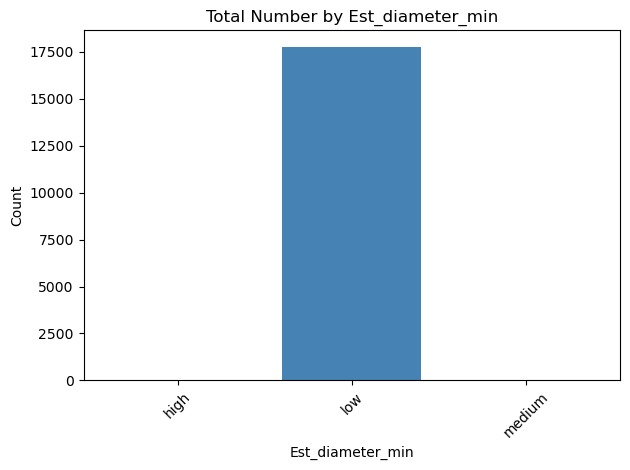

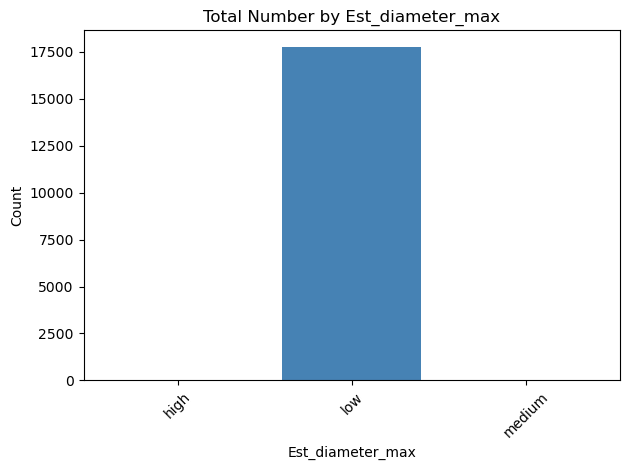

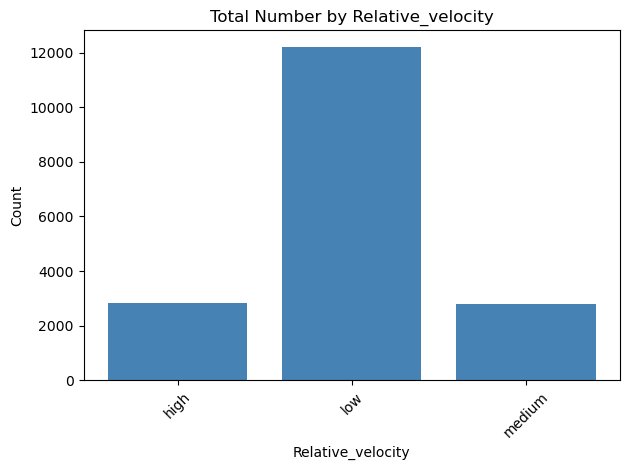

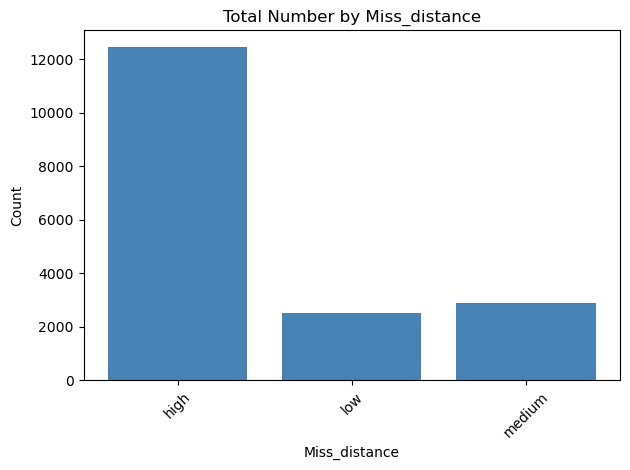

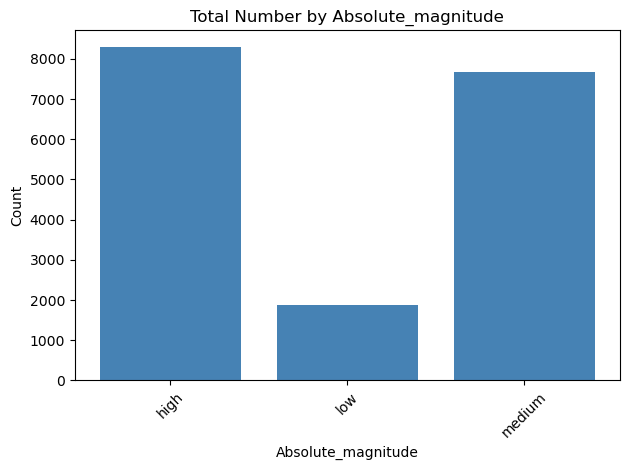

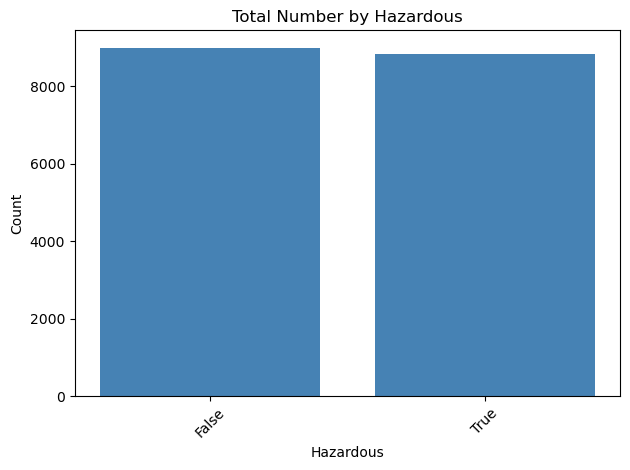

In [17]:
# load discretized table
discretized_table = MyPyTable()
discretized_table.load_from_file("/home/FinalProject/neo_discretized.csv")

# create frequency diagrams
plot_utils.plot_frequency_diagram("est_diameter_min", discretized_table.get_column("est_diameter_min"))
plot_utils.plot_frequency_diagram("est_diameter_max", discretized_table.get_column("est_diameter_max"))
plot_utils.plot_frequency_diagram("relative_velocity", discretized_table.get_column("relative_velocity"))
plot_utils.plot_frequency_diagram("miss_distance", discretized_table.get_column("miss_distance"))
plot_utils.plot_frequency_diagram("absolute_magnitude", discretized_table.get_column("absolute_magnitude"))
plot_utils.plot_frequency_diagram("hazardous", discretized_table.get_column("hazardous"))



#### Distribution Tables for Attributes (Continuous)

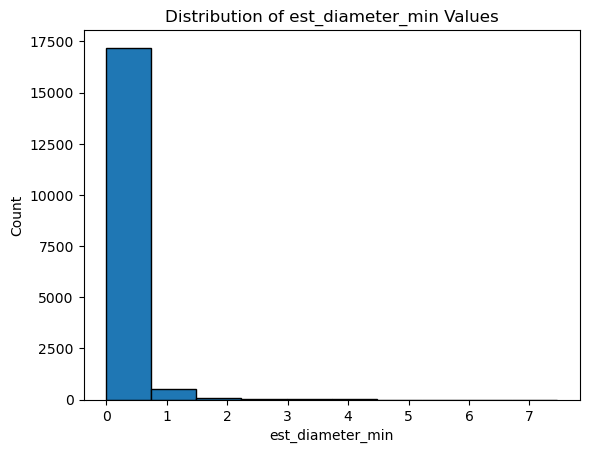

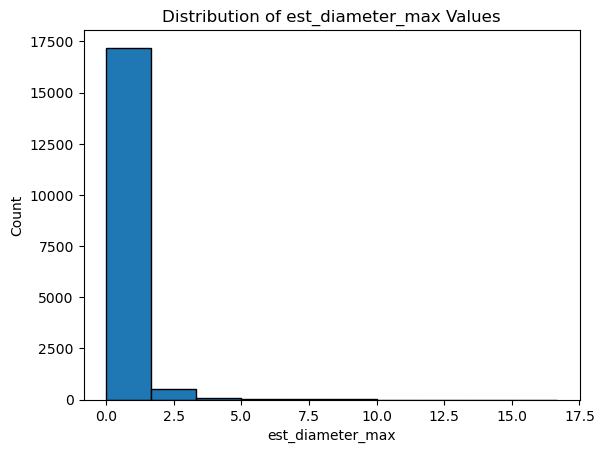

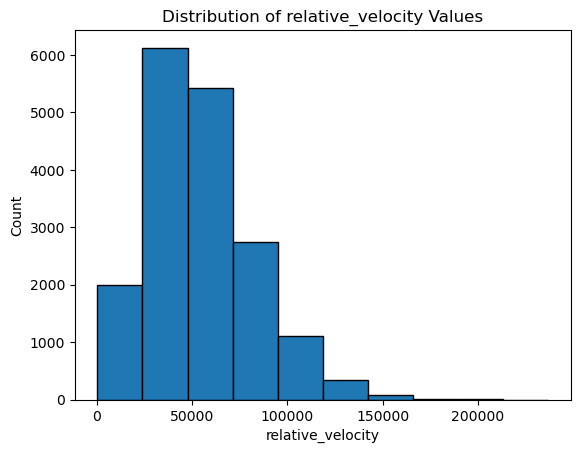

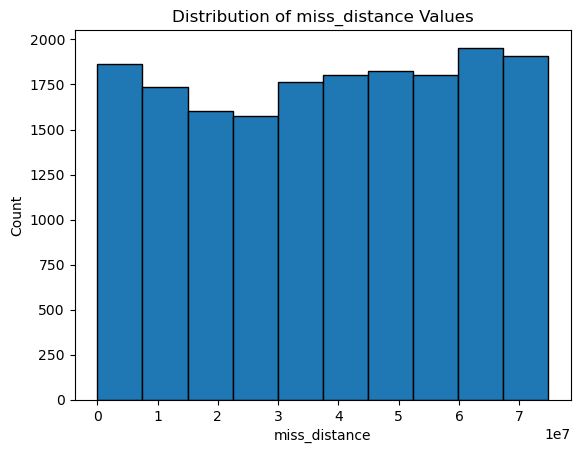

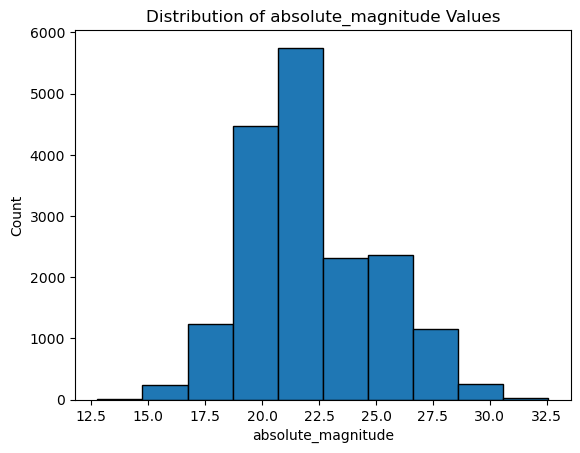

In [18]:
importlib.reload(plot_utils)

table = MyPyTable().load_from_file("/home/FinalProject/neo_clean.csv")

attributes = ["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"]

for attribute in attributes:
    column_data = table.get_column(attribute, include_missing_values=False)
    plot_utils.plot_histogram(attribute, column_data)



#### Scatter Plots for Relationships (Continuous)

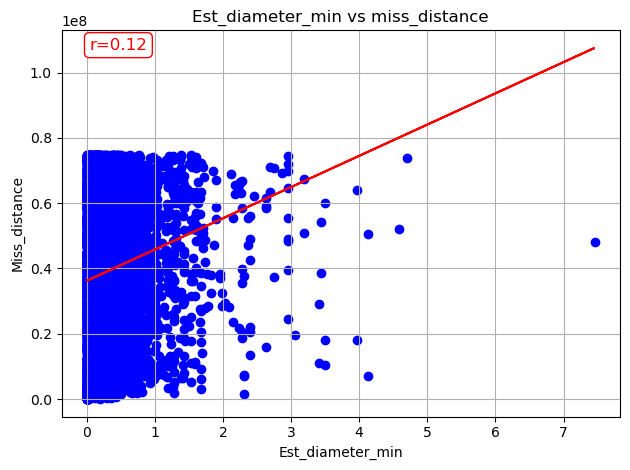

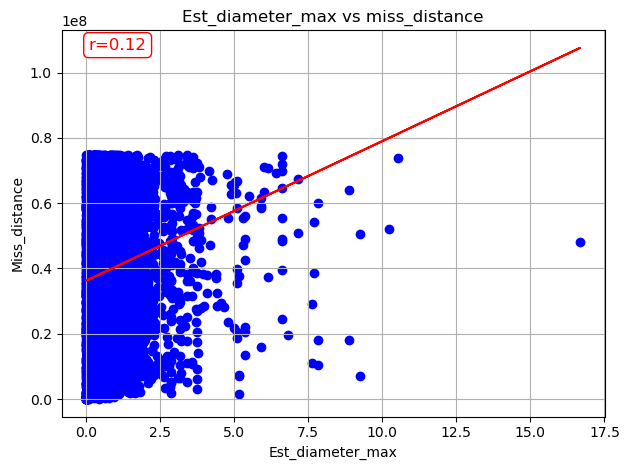

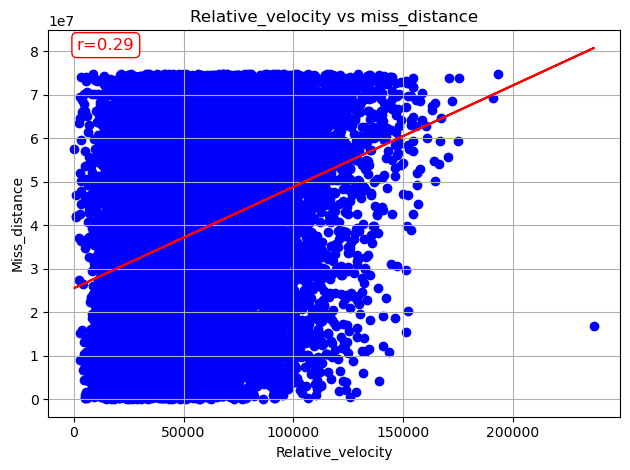

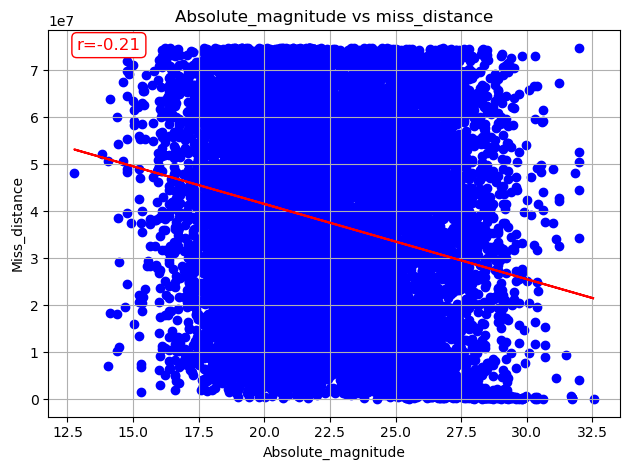

In [19]:
importlib.reload(plot_utils)

table = MyPyTable().load_from_file("/home/FinalProject/neo_clean.csv")

attributes = ["est_diameter_min", "est_diameter_max", "relative_velocity", "absolute_magnitude"]

miss_distance = [float(value) for value in table.get_column("miss_distance", include_missing_values=False)]

for attribute in attributes:
    attribute_column = [float(value) for value in table.get_column(attribute, include_missing_values=False)]
    plot_utils.plot_scatter_with_regression(attribute_column, miss_distance, attribute, "miss_distance")

# Classification Results

# Naive Bayes

In [20]:
from mysklearn.myevaluation import train_test_split, accuracy_score, binary_f1_score

X = [[row[cleaned_table.column_names.index(col)] for col in columns_to_discretize] for row in cleaned_table.data]
y = [row[cleaned_table.column_names.index("hazardous")] for row in cleaned_table.data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)

classifier = MyNaiveBayesClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
f1 = binary_f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.59
F1 Score: 0.52


## Decision Tree

In [21]:
from mysklearn.myclassifiers import MyDecisionTreeClassifier

dt_classifier = MyDecisionTreeClassifier()

X = [row[:-1] for row in discretized_table.data]
y = [row[-1] for row in discretized_table.data]

attribute_names = discretized_table.column_names[:-1]

# split data
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# train model
dt_classifier.fit(X_train, y_train)

# make prediction
y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


available attributes: ['att0', 'att1', 'att2', 'att3', 'att4']
splitting on: att2
partitions: {'medium': [['low', 'low', 'medium', 'high', 'medium', 'False'], ['low', 'low', 'medium', 'high', 'high', 'True'], ['low', 'low', 'medium', 'medium', 'medium', 'False'], ['low', 'low', 'medium', 'high', 'medium', 'True'], ['low', 'low', 'medium', 'medium', 'medium', 'True'], ['low', 'low', 'medium', 'high', 'medium', 'True'], ['low', 'low', 'medium', 'high', 'high', 'False'], ['low', 'low', 'medium', 'high', 'medium', 'True'], ['low', 'low', 'medium', 'high', 'high', 'True'], ['low', 'low', 'medium', 'high', 'high', 'False'], ['low', 'low', 'medium', 'high', 'high', 'False'], ['low', 'low', 'medium', 'medium', 'high', 'False'], ['low', 'low', 'medium', 'medium', 'high', 'False'], ['low', 'low', 'medium', 'high', 'high', 'True'], ['low', 'low', 'medium', 'high', 'high', 'True'], ['low', 'low', 'medium', 'medium', 'medium', 'True'], ['low', 'low', 'medium', 'high', 'high', 'True'], ['low', 'low'